## Benchmarking bounded sub-optimal A* ##

In [1]:
import random

from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import math
from random import randint, random, seed
from heapq import heappop, heappush
from time import sleep

In [2]:
class Map:

    def __init__(self):
        """
        Default constructor
        """

        self._width = 0
        self._height = 0
        self._cells = []

    def read_from_string(self, cell_str, width, height):
        """
        Converting a string (with '#' representing obstacles and '.' representing free cells) to a grid
        """
        self._width = width
        self._height = height
        self._cells = [[0 for _ in range(width)] for _ in range(height)]
        cell_lines = cell_str.split("\n")
        i = 0
        j = 0
        for l in cell_lines:
            if len(l) != 0:
                j = 0
                for c in l:
                    if c == '.':
                        self._cells[i][j] = 0
                    elif c == '#':
                        self._cells[i][j] = 1
                    else:
                        continue
                    j += 1
                if j != width:
                    raise Exception("Size Error. Map width = ", j, ", but must be", width)

                i += 1

        if i != height:
            raise Exception("Size Error. Map height = ", i, ", but must be", height)

    def set_grid_cells(self, width, height, grid_cells):
        """
        Initialization of map by list of cells.
        """
        self._width = width
        self._height = height
        self._cells = grid_cells

    def in_bounds(self, i, j):
        """
        Check if the cell is on a grid.
        """
        return (0 <= j < self._width) and (0 <= i < self._height)

    def traversable(self, i, j):
        """
        Check if the cell is not an obstacle.
        """
        return not self._cells[i][j]

    def get_neighbors(self, i, j):
        """
        Get a list of neighbouring cells as (i,j) tuples.
        It's assumed that grid is 8-connected (i.e. movements in cardinal and diagonal directions are allowed)
        """
        neighbors = []
        delta = [[0, 1], [1, 0], [0, -1], [-1, 0]]

        for d in delta:
            if self.in_bounds(i + d[0], j + d[1]) and self.traversable(i + d[0], j + d[1]):
                neighbors.append((i + d[0], j + d[1]))
                
        delta = [[1, 1], [1, -1], [-1, -1], [-1, 1]]
        for d in delta:
            if self.in_bounds(i + d[0], j + d[1]) and self.traversable(i + d[0], j + d[1]) and self.traversable(i, j + d[1]) and self.traversable(i + d[0], j):
                neighbors.append((i + d[0], j + d[1]))

        return neighbors

    def get_size(self):
        return self._height, self._width

In [3]:
def compute_cost(i1, j1, i2, j2):
    '''
    Estimate cost of simple moves between cells
    '''
    d = abs(i1 - i2) + abs(j1 - j2)
    if d == 1:  # cardinal move
        return 1
    elif d == 2:  # diagonal move
        return math.sqrt(2)
    else:
        raise Exception('Trying to compute the cost of non-supported move!')

In [4]:
class Node:
    """
    Node class represents a search node

    - i, j: coordinates of corresponding grid element
    - g: g-value of the node
    - h: h-value of the node
    - f: f-value of the node
    - parent: pointer to the parent-node
    - g_is_true_cost: flag that shows whether the g-value wath precisely computed or just estimated
    
    You might want to add other fields, methods for Node, depending on how you prefer to implement OPEN/CLOSED further on
    """

    def __init__(self, i, j, g=0, h=0, f=None, parent=None, g_is_true_cost = False):
        self.i = i
        self.j = j
        self.g = g
        self.h = h
        self.g_is_true_cost = g_is_true_cost
        if f is None:
            self.f = self.g + h
        else:
            self.f = f
        self.parent = parent

    def __eq__(self, other):
        '''
        Estimating where the two search nodes are the same,
        which is needed to detect dublicates in the search tree.
        '''
        return (self.i == other.i) and (self.j == other.j)
    
    def __hash__(self):
        '''
        To implement CLOSED as set of nodes we need Node to be hashable.
        '''
        ij = self.i, self.j
        return hash(ij)

    def __lt__(self, other) -> object:
        """
        Comparison between self and other. Returns is self < other (self has higher priority).
        """
        return self.f < other.f or ((self.f == other.f) and (self.h < other.h))

In [6]:
class SearchTreePQS:
    
    def __init__(self):
        self._open = []           # heap for the OPEN nodes
        self._closed = set()       # set for the expanded nodes = CLOSED
        self._enc_open_dublicates = 0
        
    def __len__(self):
        return len(self._open) + len(self._closed)
                    
    '''
    open_is_empty should inform whether the OPEN is exhausted or not.
    In the former case the search main loop should be interrupted.
    '''
    
    def open_is_empty(self):
        return len(self._open) == 0
    
    '''
    Adding a (previously not expanded) node to the search-tree (i.e. to OPEN).
    It's either a totally new node (the one we never encountered before)
    or it can be a dublicate of the node that currently resides in OPEN.
    It's up to us how to handle dublicates in OPEN. We can either 
    detect dublicates upon adding (i.e. inside this method) or detect them
    lazily, when we are extracting a node for further expansion.
    Not detecting dublicates at all may work in certain setups but let's not
    consider this option.
    '''    
    def add_to_open(self, item):
        heappush(self._open, item)   
    
    '''
    Extracting the best node (i.e. the one with the minimal key 
    = min f-value = min g-value (for Dijkstra)) from OPEN.
    This node will be expanded further on in the main loop of the search.
    ''' 
    
    def was_expanded(self, item):
        return item in self._closed
    
    def get_best_node_from_open(self):
        best_node = heappop(self._open)
        
        while self.was_expanded(best_node) and not self.open_is_empty():
            best_node = heappop(self._open)
        
        return best_node

    def add_to_closed(self, item):
        self._closed.add(item)

    @property
    def OPEN(self):
        return self._open
    
    @property
    def CLOSED(self):
        return self._closed

    @property
    def number_of_open_dublicates(self):
        return self._enc_open_dublicates

In [7]:
def make_path(goal):
    '''
    Creates a path by tracing parent pointers from the goal node to the start node
    It also returns path's length.
    '''

    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

In [9]:
def euclid_distance(i1, j1, i2, j2):
    return np.sqrt((i1 - i2) ** 2 + (j1 - j2) ** 2)

def octile_distance(i1, j1, i2, j2):
    return (np.sqrt(2) * min(abs(i1 - i2), abs(j1 - j2)) + 
            (max(abs(i1 - i2), abs(j1 - j2)) - min(abs(i1 - i2), abs(j1 - j2))))

In [10]:
def astar(grid_map, start_i, start_j, goal_i, goal_j, heuristic_func = None, search_tree = None):
    '''
    Modified Dijkstra algorithm for monotonous heuristics
    '''
    ast = search_tree()
    steps = 0
    nodes_created = 0
    
    goal = (goal_i, goal_j)
    start = Node(start_i, start_j, 0, heuristic_func(start_i, start_j, *goal), parent=None)
    ast.add_to_open(start)
    
    while not ast.open_is_empty():
        steps += 1
        best_node = ast.get_best_node_from_open()
        best = (best_node.i, best_node.j)
        ast.add_to_closed(best_node)
        
        
        if (best == goal):
            return True, best_node, steps, nodes_created, ast.OPEN, ast.CLOSED
        
        for succ in grid_map.get_neighbors(*best):
            new_node = Node(*succ, best_node.g + compute_cost(*best, *succ), heuristic_func(*succ, *goal), parent=best_node)
            nodes_created += 1
            if not ast.was_expanded(new_node):
                ast.add_to_open(new_node)
    return False, None, steps, nodes_created, ast.OPEN, ast.CLOSED

In [11]:
def sub_optimal_astar(grid_map, start_i, start_j, goal_i, goal_j, sub_optimal_factor = 1, heuristic_func = None, search_tree = None):
    '''
    TODO
    '''
    ast = search_tree()
    steps = 0
    nodes_created = 0
    expansions = 0
    transitions_computed = 0
    
    EDGES = dict()
    
    goal = (goal_i, goal_j)
    start = Node(start_i, start_j, 0, heuristic_func(start_i, start_j, *goal), parent=None)
    ast.add_to_open(start)
    
    while not ast.open_is_empty():
        steps += 1
        expansions += 1
        best_node = ast.get_best_node_from_open()
        best = (best_node.i, best_node.j)
        ast.add_to_closed(best_node)
        
        if (best == goal):
            return True, best_node, expansions, transitions_computed, nodes_created, ast.OPEN, ast.CLOSED, EDGES
        
        for succ in grid_map.get_neighbors(*best):
            new_node = Node(*succ, best_node.g + compute_cost(*best, *succ), sub_optimal_factor * heuristic_func(*succ, *goal), parent=best_node)
            EDGES[(*best, * succ)] = True
            transitions_computed += 1
            nodes_created += 1
            if not ast.was_expanded(new_node):
                ast.add_to_open(new_node)           
        
    CLOSED = ast.expanded
    nodes_created = len(ast)
    return False, None, expansions, transitions_computed, nodes_created, None, CLOSED, EDGES

In [14]:
def read_map_from_file(path):
    '''
    Reads map
    '''

    tasks_file = open(path)
    someline = tasks_file.readline()
    height = int(tasks_file.readline().split()[1])
    width = int(tasks_file.readline().split()[1])
    someline = tasks_file.readline()
    cells = [[0 for _ in range(width)] for _ in range(height)]
    i = 0
    j = 0


    for l in tasks_file:
        j = 0
        for c in l:
            if c in ['.', "W", "T", "S"]:
                cells[i][j] = 0
            elif c in ['#', "@"]:
                cells[i][j] = 1
            else:
                continue
            j += 1
                
        i += 1
        if(i == height):
            break
            
    return (width, height, cells)

import numpy as np

def read_task_from_file(path, task_num, seed):
    '''
    Reads start/goal positions and true value of path length between given start and goal from file by path. 
    '''
    
    tasks_file = open(path)
    
    data = tasks_file.read()
    lines = data.split('\n')
    line_choice = np.random.default_rng(seed).integers(1, len(lines), size=task_num)
    starts_i, starts_j, goals_i, goals_j, lengths = [], [], [], [], []
    for l in line_choice:
        line = lines[l]
        level, task_name, height, width, start_i, start_j, goal_i, goal_j, length = line.split()
        starts_i.append(int(start_i))
        starts_j.append(int(start_j))
        goals_i.append(int(goal_i))
        goals_j.append(int(goal_j))
        lengths.append(float(length))
    
    return (starts_i, starts_j, goals_i, goals_j, lengths)

In [15]:
from time import time 
from joblib import Parallel, delayed

def massive_test(search_func, data_path, num_of_tasks=None, factors = [1], seed=100, *args):    
    stat = {}
    
    if (num_of_tasks is None) or (num_of_tasks<=0):
        print("Incorrect number of tasks. Testing halted!")
        return stat
    
    task_num = num_of_tasks
    task_map = Map()
    
    def get_stat(factor):
        st = {
            "steps": {key: [] for key in range(1, 6)},
            "error_percentage": {key: [] for key in range(1, 6)},
            "hardness_length_per_heuristic": {key: [] for key in range(1, 6)},
            "Problems": {key: [] for key in range(1, 6)}
            }
        for task_count in range(1, 6):
            map_file_name = data_path + str(task_count) + ".map"
            task_file_name = data_path + str(task_count) + ".scen"
            task_map.set_grid_cells(*read_map_from_file(map_file_name))
            starts_j, starts_i, goals_j, goals_i, lengths = read_task_from_file(task_file_name, task_num, seed)

            for i in range(task_num):
                start_i, start_j, goal_i, goal_j, length = starts_i[i], starts_j[i], goals_i[i], goals_j[i], lengths[i]
                try:
                    t1 = time()
                    if factor == 1:
                        result = search_func(task_map, start_i, start_j, goal_i, goal_j, *args)
                    else:
                        result = search_func(task_map, start_i, start_j, goal_i, goal_j, factor, *args)
                    t2 = time()
                    number_of_steps = result[2]
                    nodes_created = result[3]
                    if result[0]:
                        st["hardness_length_per_heuristic"][task_count].append(length / euclid_distance(start_i, start_j, goal_i, goal_j))
                        st["steps"][task_count].append(number_of_steps) 
                        path = make_path(result[1]) 
                        st["error_percentage"][task_count].append(abs(path[1] / length))
                        correct = abs(path[1] / length) <= factor
                        if not correct:
                            st["Problems"][task_count] += 1
                    else:
                        print("Path not found!")

                except Exception as e:
                    print("Execution error")
                    print(e)
        return st
    
    results = Parallel(n_jobs=-1)(delayed(get_stat)(factor) for factor in factors)
    stat = {key: value for key, value in zip(factors, results)}
    return stat

Map: 1


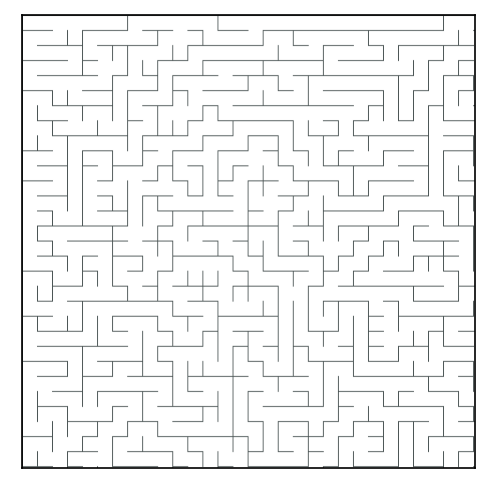

Map: 2


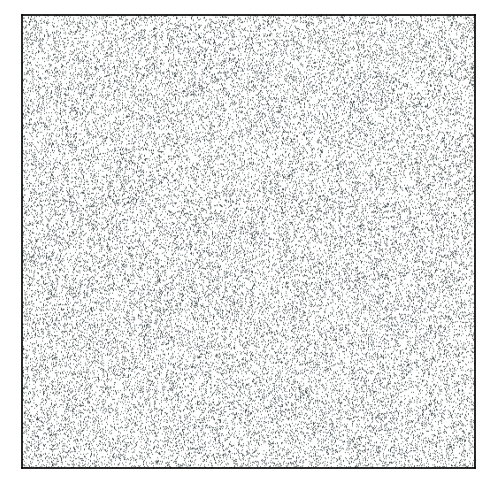

Map: 3


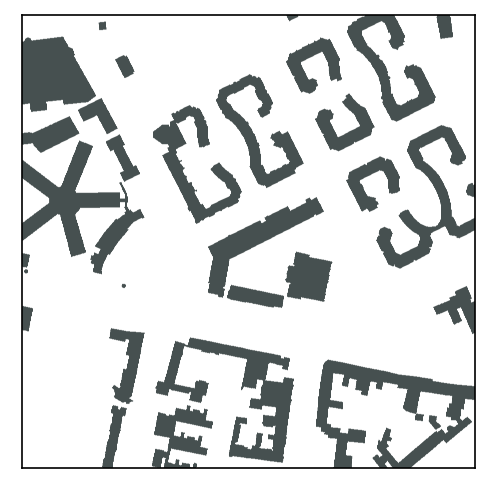

Map: 4


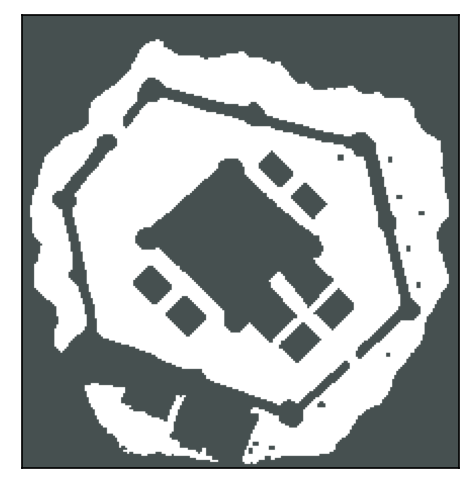

Map: 5


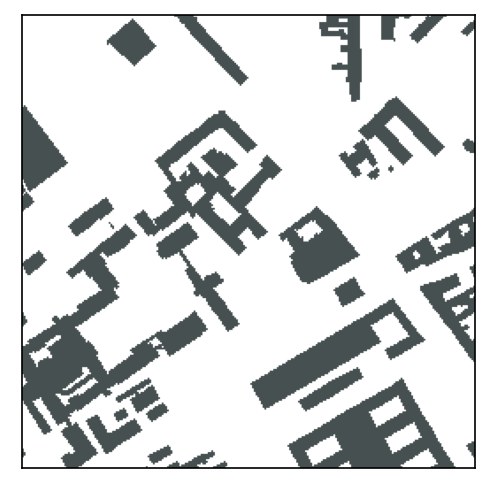

In [16]:
data_path = "data/"
task_map = Map()
for task_count in range(1, 6):   
        map_file_name = data_path + str(task_count) + ".map"
        task_file_name = data_path + str(task_count) + ".scen"
        task_map.set_grid_cells(*read_map_from_file(map_file_name))
        print(f"Map: {task_count}")
        draw(task_map)

Выше представлены карты, которые я взял, вторая карта, довольно большая, остальные, походят на то, что было в лабах. Третья и пятая карта предполагаю обход объектов "средней" длины. На четвертой карте, в зависимости от задания возможно придется сделать очень большую петлю, чем заходить внутрь ограниченной области. Первая карта предполагает какие-то совсем не тривиальные пути, карта выглядит как лабиринт, очень интересно, что же на ней получится.

В тестах зафиксировали seed, чтобы для большего понимания, что происзодит запускать тесты на одинаковых картах.

In [17]:
n = 100
%time  sub_optimal_stats = massive_test(sub_optimal_astar, "data/", n, [1.05, 1.1, 1.5, 2, 3, 5], 100, octile_distance, SearchTreePQS)
%time  astar_stats = massive_test(astar, "data/", n, [1], 100, octile_distance, SearchTreePQS)
for i in  [1.05, 1.1, 1.5, 2, 3, 5]:   
    print(sub_optimal_stats[i]["Problems"])
astar_stats[1]["Problems"]

CPU times: total: 62.5 ms
Wall time: 45min 44s
CPU times: total: 31.2 ms
Wall time: 37min 18s
{1: [], 2: [], 3: [], 4: [], 5: []}
{1: [], 2: [], 3: [], 4: [], 5: []}
{1: [], 2: [], 3: [], 4: [], 5: []}
{1: [], 2: [], 3: [], 4: [], 5: []}
{1: [], 2: [], 3: [], 4: [], 5: []}
{1: [], 2: [], 3: [], 4: [], 5: []}


{1: [], 2: [], 3: [], 4: [], 5: []}

Мы видим, что на всех картах, мы слава богу остаемся суб-оптимальными.

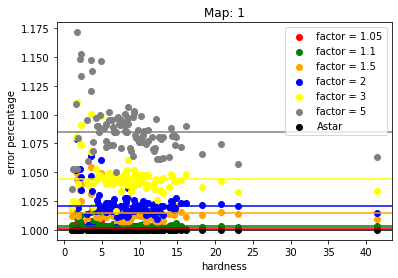

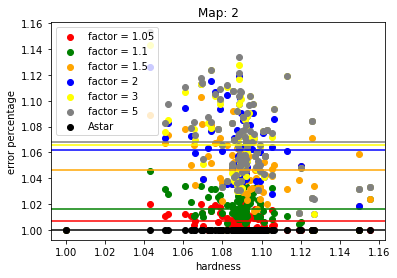

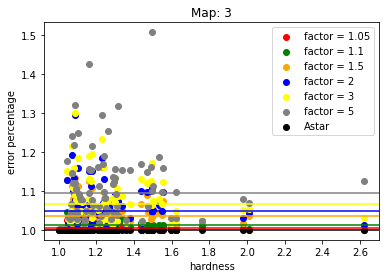

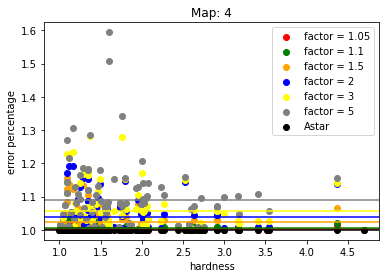

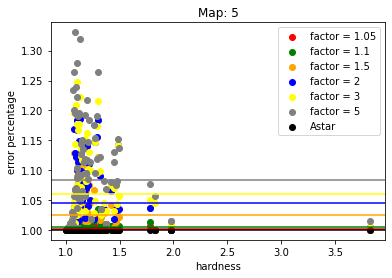

In [39]:
import matplotlib.pyplot as plt

factors = [1.05, 1.1, 1.5, 2, 3, 5]
colors = ["red", "green", "orange", "blue", "yellow", "grey"] 
for Map_num in range(1, 6): 
    for factor, col in zip(factors, colors):
        plt.scatter(sub_optimal_stats[factor]["hardness_length_per_heuristic"][Map_num], sub_optimal_stats[factor]["error_percentage"][Map_num],  c=col, label=f"factor = {factor}")        
        plt.axhline(y=np.mean(sub_optimal_stats[factor]["error_percentage"][Map_num]),  color=col, linestyle='-')
    plt.scatter(astar_stats[1]["hardness_length_per_heuristic"][Map_num], astar_stats[1]["error_percentage"][Map_num], c="black", label="Astar")
    plt.axhline(y=1,  color="black", linestyle='-')
    plt.title(f"Map: {Map_num}")
    plt.xlabel("hardness")
    plt.ylabel("error percentage")
    plt.legend()
    plt.show()

Мы видим интересную ситуацию, что в среднем алгоритмы для всех факторов не выходят за 1.1, хотя изначально все факторы не больше, чем 1.1.  Большую ошибку мы вообще почти никогда не получаем, даже с параметром 5, мы получаем почти всегда ошибку не больше 1.5, заметим, что для большой второй карты. Посмотрим на это локально от 1 до 1.1

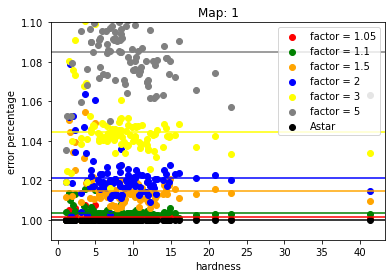

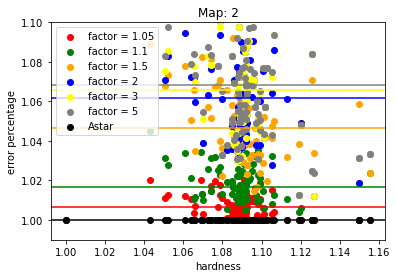

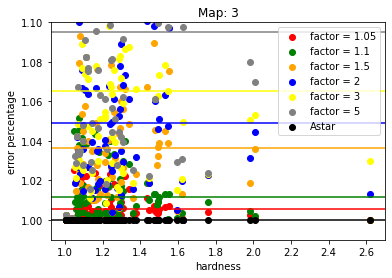

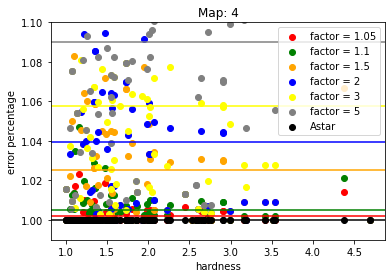

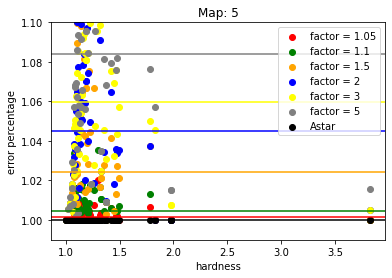

In [38]:
factors = [1.05, 1.1, 1.5, 2, 3, 5]
colors = ["red", "green", "orange", "blue", "yellow", "grey"] 
for Map_num in range(1, 6): 
    plt.ylim(.99, 1.1)
    for factor, col in zip(factors, colors):
        plt.scatter(sub_optimal_stats[factor]["hardness_length_per_heuristic"][Map_num], sub_optimal_stats[factor]["error_percentage"][Map_num],  c=col, label=f"factor = {factor}")        
        plt.axhline(y=np.mean(sub_optimal_stats[factor]["error_percentage"][Map_num]),  color=col, linestyle='-')
    plt.scatter(astar_stats[1]["hardness_length_per_heuristic"][Map_num], astar_stats[1]["error_percentage"][Map_num], c="black", label="Astar")
    plt.axhline(y=1,  color="black", linestyle='-')
    plt.xlabel("hardness")
    plt.ylabel("error percentage")
    plt.title(f"Map: {Map_num}")
    plt.legend()
    plt.show()

В целом картинки все очень похожи, средние пропорциональны значениям факторов примерно. И в среднем значения гораздо меньше разрешенной ошибки (например, когда мы разрешаем ошибку 5% ошибка меньше процента в среднем).

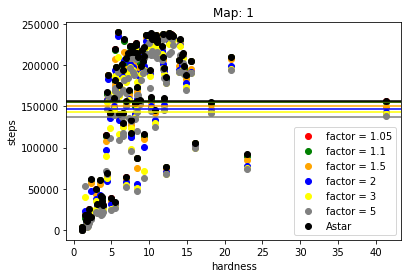

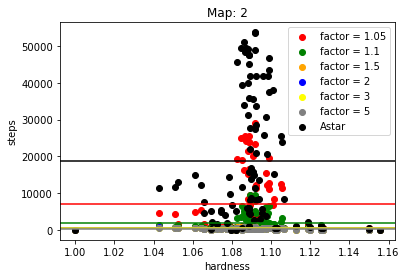

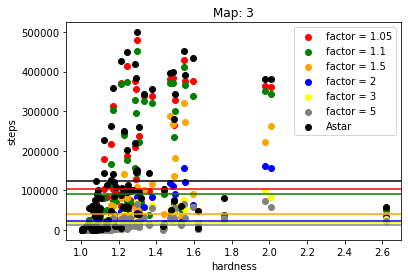

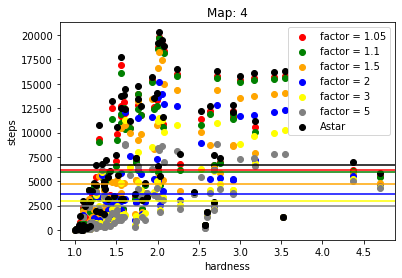

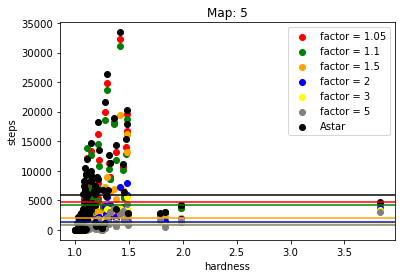

In [37]:
import matplotlib.pyplot as plt

factors = [1.05, 1.1, 1.5, 2, 3, 5]
colors = ["red", "green", "orange", "blue", "yellow", "grey"] 
for Map_num in range(1, 6): 
    for factor, col in zip(factors, colors):
        plt.scatter(sub_optimal_stats[factor]["hardness_length_per_heuristic"][Map_num], sub_optimal_stats[factor]["steps"][Map_num],  c=col, label=f"factor = {factor}")        
        plt.axhline(y=np.mean(sub_optimal_stats[factor]["steps"][Map_num]),  color=col, linestyle='-')
    plt.scatter(astar_stats[1]["hardness_length_per_heuristic"][Map_num], astar_stats[1]["steps"][Map_num], c="black", label="Astar")
    plt.axhline(y=np.mean(astar_stats[1]["steps"][Map_num]),  color="black", linestyle='-')
    plt.title(f"Map: {Map_num}")
    plt.xlabel("hardness")
    plt.ylabel("steps")
    plt.legend()
    plt.show()

На маленьких картах мы не видим особой разницы, когда параметр маленький. При больших параметра хотя бы 1.5 мы уже прилично отдаляемся от обычного A*. 
Заметим, что на большой карте мы получили уже очень большую разницу.

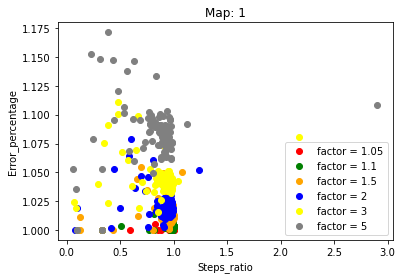

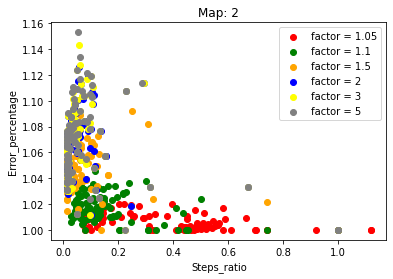

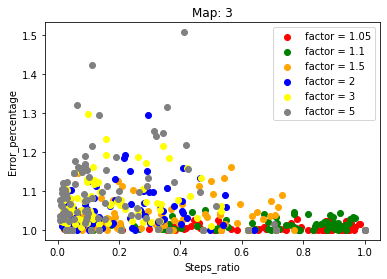

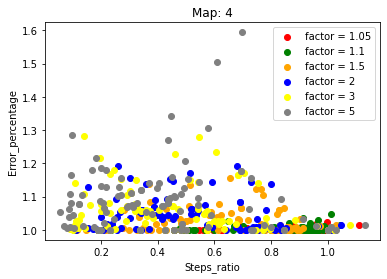

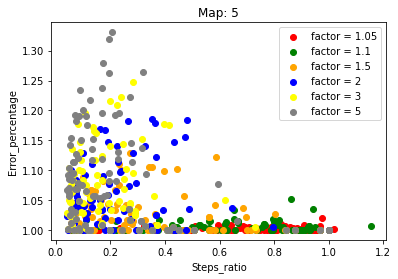

In [24]:
factors = [1.05, 1.1, 1.5, 2, 3, 5]
colors = ["red", "green", "orange", "blue", "yellow", "grey"] 
for Map_num in range(1, 6): 
    for factor, col in zip(factors, colors):
        x = [a / b for a, b in zip(sub_optimal_stats[factor]["steps"][Map_num], astar_stats[1]["steps"][Map_num])]
        y = [c / d for c, d in zip(sub_optimal_stats[factor]["error_percentage"][Map_num], astar_stats[1]["error_percentage"][Map_num])]
        plt.scatter(x, y,  c=col, label=f"factor = {factor}") 
    plt.title(f"Map: {Map_num}")
    plt.xlabel("Steps_ratio")
    plt.ylabel("Error_percentage")
    plt.legend()
    plt.show()

Заметим, что на второй большой карте у нас ошибка начинает расти значительно, когда мы по времени выигрываем раз в 5 примерно. В остальном у нас большинство точек располагаются в левом нижнем углу, не на всех картах, где-то они более размазаны по х, но не может не радовать этот факт, так как это означает, что мы сильно выигрываем по времени не сильно проигрывая по эффективности. Посмотрим еще разок на большую карту и на самые большие параметры.

Mean for yellow is 0.07818157018833163
Mean for grey is 0.07793770778744244


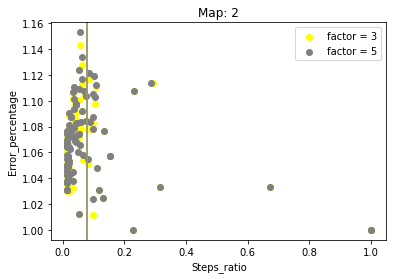

In [36]:
factors = [3, 5]
colors = ["yellow", "grey"] 
for Map_num in [2]: 
    for factor, col in zip(factors, colors):
        x = [a / b for a, b in zip(sub_optimal_stats[factor]["steps"][Map_num], astar_stats[1]["steps"][Map_num])]
        y = [c / d for c, d in zip(sub_optimal_stats[factor]["error_percentage"][Map_num], astar_stats[1]["error_percentage"][Map_num])]
        plt.scatter(x, y,  c=col, label=f"factor = {factor}")
        plt.axvline(x=np.mean(x), color=col)
        print(f"Mean for {col} is {np.mean(x)}")
    plt.title(f"Map: {Map_num}")
    plt.xlabel("Steps_ratio")
    plt.ylabel("Error_percentage")
    plt.legend()
    plt.show()


Последнее, что хочется отметить, это невероятный выйгрыш по времени, больше чем в 10 раз, хотя ошибаемся мы конечно не более, чем на 16 процентов, и это не гарантировано, но мне кажется достаточно впечатляюще, чтобы подумать об использовании. Конечно на маленьких картах такие большие значения для параметра не актуальны, потому что там проигрыш будет гораздо существеннее.  На первой карте, мы вообще получили, что исходный алгоритм работал быстрее в двух ситуациях)))

Такая впечатляющая скорость заставляет задуматься об идеи предварительного прохода подобного алгоритма с большим параметром, а потом каким-то непонятным образом использовать полученное знание в исходном алгоритме, например при выборе следующей вершины, надеясь на то, что эффективное решение или просто более эффективное недалеко от построенного.